In [1]:
import os
import sys
sys.path.append("/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

from pl_modules.PatchBoxEmbeddings import PatchBoxEmbeddings
from datasets import get_dataset

In [3]:
config_filepath = "/home/ubuntu/workspace/code/compositional-representation-learning/configs/PatchBoxEmbeddings/PatchBoxEmbeddings_exp_2.yaml"
checkpoint_filepath = "/home/ubuntu/workspace/experiment_root_dir/PatchBoxEmbeddings_exp_2/PatchBoxEmbeddings_exp_2___2025-11-05__15-32-09/checkpoints/model-epoch=099.ckpt"

with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = PatchBoxEmbeddings.load_from_checkpoint(checkpoint_filepath, config=config)
model.eval()

PatchBoxEmbeddings(
  (image_encoder): ImageEncoder(
    (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_5): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_6): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_7): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (maxpool_4): MaxPool2d(kernel_size=2, stride=2, 

In [4]:
@torch.no_grad()
def get_embeddings(model, datapoint):
    """
    Extracts key quantized embeddings from a single datapoint using the trained model.
    """
    model.eval()
    device = model.device

    # 1. Preprocess and "batchify" the single datapoint
    # The model's forward method expects a batch.
    try:
        images = datapoint['images'].unsqueeze(0).to(device)
        object_masks = datapoint['object_masks'].unsqueeze(0).to(device)
    except TypeError:
        # Handle cases where datapoint might be a list/tuple
        images = datapoint[0].unsqueeze(0).to(device)
        object_masks = datapoint[1].unsqueeze(0).to(device)

    # --- This logic is extracted directly from your model's forward() method ---

    # 2. Get patches and bounding box
    batch_image_patches = model.divide_image_into_patches(images) # (1, grid_h, grid_w, C, patch_h, patch_w)
    batch_mask_patches = model.divide_image_into_patches(object_masks.unsqueeze(1)) # (1, grid_h, grid_w, 1, patch_h, patch_w)
    batch_bounding_boxes = model.compute_bounding_boxes(batch_mask_patches) # (1, 4)

    # 3. Extract single-item data (remove batch dim)
    image_patches = batch_image_patches[0] # (grid_h, grid_w, C, patch_h, patch_w)
    bounding_box = batch_bounding_boxes[0] # (4,)

    # 4. Get object-specific patches
    object_patches = image_patches[bounding_box[0]:bounding_box[2] + 1, bounding_box[1]:bounding_box[3] + 1]
    object_region = model.stitch_object_patches(object_patches)
    bbox_grid_h, bbox_grid_w, C, patch_h, patch_w = object_patches.shape
    num_patches = bbox_grid_h * bbox_grid_w
    object_patches_flattened = object_patches.reshape(num_patches, C, patch_h, patch_w)

    # 5. Handle edge case (from your original code)
    if num_patches <= 2:
        print(f"Warning: Only {num_patches} object patches found. Skipping this datapoint.")
        return None

    # 6. Resize and encode
    # Assuming input images for the encoder are 224x224 as in your training code
    object_patches_resized = F.interpolate(object_patches_flattened, size=(224, 224), mode="bilinear", align_corners=False)
    object_region_resized = F.interpolate(object_region.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)
    encoder_output = model.image_encoder(torch.cat([object_patches_resized, object_region_resized], dim=0))

    object_patch_embeddings = encoder_output[:-1]
    object_region_embedding = encoder_output[-1].unsqueeze(0)

    # 7. Get positional embeddings
    object_grid_coords_normalized = model.compute_positional_data(object_patches)
    object_positional_embeddings = model.positional_encoder(object_grid_coords_normalized)

    # 8. Quantize to get the 4 desired outputs
    
    # Output 1: Quantized patch representations
    quantized_patch_embeddings, _, _ = model.vq(object_patch_embeddings)
    
    # Output 2: Quantized position representations
    quantized_positional_embeddings, _, _ = model.vq(object_positional_embeddings)

    # Output 4: The computed object region representation
    quantized_object_region_embedding, _, _ = model.vq(object_region_embedding)

    # 9. Get "correct" parent set intersection
    
    # Compute all N*N parent embeddings
    parent_embeddings, _ = model.compute_parent_embeddings(quantized_patch_embeddings, quantized_positional_embeddings)
    
    # Get the diagonal (pos_i, patch_i)
    correct_parent_set = torch.diagonal(parent_embeddings, 0).permute(1, 0)
    
    # Output 3: The "correct" parent set representation (intersection)
    correct_parent_intersection_box = model.compute_overall_intersection_box(correct_parent_set)

    # 10. Return the 4 requested items
    return {
        "quantized_patch_embeddings": quantized_patch_embeddings,
        "quantized_positional_embeddings": quantized_positional_embeddings,
        "correct_parent_intersection_box": correct_parent_intersection_box,
        "quantized_object_region_embedding": quantized_object_region_embedding
    }

In [5]:
dataset = get_dataset(config)

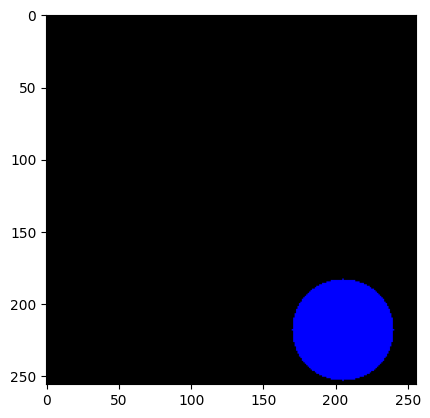

In [6]:
datapoint = dataset[0]
embeddings = get_embeddings(model, datapoint)

plt.imshow(datapoint["images"].permute(1, 2, 0).cpu().numpy())


In [7]:
embeddings["quantized_patch_embeddings"]

tensor([[-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231],
        [-0.0576,  0.0065, -0.0769,  0.4

In [8]:
embeddings["quantized_positional_embeddings"]

tensor([[-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203],
        [-0.0538, -0.0086, -0.0797,  0.4

In [9]:
embeddings["correct_parent_intersection_box"]

tensor([[-0.0538, -0.0086, -0.0797,  0.4462,  0.4914,  0.4203]],
       device='cuda:0')

In [10]:
embeddings["quantized_object_region_embedding"]

tensor([[-0.0576,  0.0065, -0.0769,  0.4424,  0.5065,  0.4231]],
       device='cuda:0')

In [ ]:
numpy_embeddings_dict = {
    key: value.cpu().numpy() if isinstance(value, torch.Tensor) else value
    for key, value in embeddings.items()
}

with open("/home/ubuntu/workspace/code/compositional-representation-learning/tmp/emb_1.pkl", "wb") as f:
    pickle.dump(numpy_embeddings_dict, f)